In [1]:
import tensorflow as tf
import keras
from keras.layers import Input ,Dense, Dropout, Activation, LSTM, Bidirectional
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Reshape, BatchNormalization, Add, MaxPooling1D
from keras.models import Sequential
from keras.layers.wrappers import TimeDistributed
from keras.layers.pooling import GlobalAveragePooling2D
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.models import Model
from keras.optimizers import Adam
from keras.engine.network import Network
from keras import backend as K
from keras.utils import Sequence

import keras.backend.tensorflow_backend as KTF

from keras.initializers import glorot_normal,orthogonal

from keras.callbacks import EarlyStopping,TensorBoard
import csv

from PIL import Image

%matplotlib inline

import matplotlib.pyplot as plt

import numpy as np
import cv2
import os
import random

from tqdm import tqdm

# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.4
# sess = tf.Session(config=config)
# K.set_session(sess)


config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.visible_device_list = "0"
K.set_session(tf.Session(config=config))

Using TensorFlow backend.


In [2]:
#どんくらいで学習させるか関連
timesteps=10 #一回のLSTMに入れる値の数
camera=5 #カメラの数

rate = 10 #飛ばすフレーム数（30FPSを30/rateのFPSの動画に疑似変換する．）

#画像関連 
channels=3
img_width=50
img_height=50

#LSTMなどで用いる値
epochs = 100 # エポック数 
batch_size = 5 # バッチサイズ

In [3]:
class DataLoader(Sequence):
    def __init__(self, camera_num, file_name, rate, width, height):
        self.camera_num = camera_num
        self.file_name =file_name
        self.samples=0
        self.rate = rate
        self.width=width
        self.height=height
        self.save_numpy()
        
    def save_numpy(self):
        self.samples = int(self.get_sample()/self.rate)
        if not (os.path.isfile(self.file_name+"train/label_"+str(self.rate)+".npy")):
            self.make_numpy_learnData()
            self.make_numpy_labelData()
        self.learnData=np.load(self.file_name+"train/learn_"+str(self.rate)+".npy")
        self.labelData=np.load(self.file_name+"train/label_"+str(self.rate)+".npy")
        
        
    
    def get_sample(self):
        video_path = self.file_name+"video/0.mp4"
        cap = cv2.VideoCapture(video_path)
        num = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        return num
    
    def make_numpy_labelData(self):
        labelData=[[],[],[],[],[]]
        test=[0,0,0,0,0]
        csv_selection=csv.reader(open(self.file_name+"video/mintime_optimize.csv", 'r'))
        for i,row2 in enumerate(csv_selection):
            if(i%self.rate==0):
                for j in range(self.camera_num):
                    if j == int(row2[1]):
                        labelData[j].append([1])
                    else:
                        labelData[j].append([0])
                test[int(row2[1])]+=1
        
        
        tmp_list = np.array(labelData)
        tmp_list = tmp_list.astype(np.float)
        np.save(self.file_name+"train/label_"+str(self.rate)+".npy", tmp_list)
        print(tmp_list.shape)
        print(test)
        
    def make_numpy_learnData(self):
        learnData=[]
        for i in range(0, self.camera_num):
            print()
            img_list=[]
            video_path = self.file_name+"video/"+str(i)+".mp4"
            cap = cv2.VideoCapture(video_path)
            video_len = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            for j in range(0,video_len):
                
                pro_size=20
                bar = int(j*pro_size/video_len)
                pro_bar = ('=' * bar) + (' ' * (pro_size - bar))
                percent ='{:03f}'.format(j / video_len * 100.)
                print('\r{0}/{1} [{2}] {3}%'.format((i+1), self.camera_num, pro_bar, percent), end='')
                
                ret, frame = cap.read()
                if(j%self.rate==0):
                    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    img=Image.fromarray(frame)
                    img = img.resize((self.width, self.height))
                    x = np.array(img, dtype=np.float32)
                    x = x / 255.
                    img_list.append(x)
            learnData.append(img_list)
            
        tmp_list=np.array(learnData)
        tmp_list=tmp_list.astype(np.float)
        np.save(self.file_name+"train/learn_"+str(self.rate)+".npy", tmp_list)
        print(tmp_list.shape)
    
        
    def get_learndata(self):
        data_name=self.file_name+"train/learn_"+str(self.rate)+".npy"
        test=np.load(data_name)
        return test
    
    def get_labeldata(self):
        data_name=self.file_name+"train/label_"+str(self.rate)+".npy"
        test=np.load(data_name)
        return test
    
    def show(self):
        print(self.get_learndata().shape)
        print(self.get_labeldata().shape)

In [4]:
data = DataLoader(camera, "./data/20190427/", rate, img_width, img_height)
data.show()

(5, 1620, 50, 50, 3)
(5, 1620, 1)


In [5]:
class Resnet18 :
    ##
    ##　Resnet-18の作成
    ##
    def __init__(self, width, height, channels):
        self.img_rows=height
        self.img_cols=width
        self.img_channels=channels
    
    def rescell(self, data, filters, kernel_size, option=False):
        strides=(1,1)
        if option:
            strides=(2,2)
        x=Convolution2D(filters=filters,kernel_size=kernel_size,strides=strides,padding="same")(data)
        x=BatchNormalization()(x)
        x=Activation('relu')(x)
        
        data=Convolution2D(filters=int(x.shape[3]), kernel_size=(1,1), strides=strides, padding="same")(data)
        x=Convolution2D(filters=filters,kernel_size=kernel_size,strides=(1,1),padding="same")(x)
        x=BatchNormalization()(x)
        x=Add()([x,data])
        x=Activation('relu')(x)
        
        return x
    
    def create_resnet18(self):
        inputs=Input(shape=(self.img_rows, self.img_cols, self.img_channels))
        x=Convolution2D(64,(7,7), padding="same", input_shape=(self.img_rows, self.img_cols),activation="relu")(inputs)
        x=MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(x)

        x=self.rescell(x,64,(3,3))
        x=self.rescell(x,64,(3,3))
        x=self.rescell(x,64,(3,3))
        
        x=self.rescell(x,128,(3,3),True)
        x=self.rescell(x,128,(3,3))

        x=self.rescell(x,256,(3,3),True)
        x=self.rescell(x,256,(3,3))
        
        x=self.rescell(x,512,(3,3),True)
        x=self.rescell(x,512,(3,3))
        
        model=Model(inputs=inputs,outputs=[x])
        return model

    def get_resnet18(self):
        return self.create_resnet18()

In [6]:
class Prediction :
    def __init__(self, timesteps, n_out, width, height):
        self.maxlen = 2*timesteps+1
        self.n_out = n_out
        self.width=width
        self.height=height
        self.resnet = Resnet18(width, height, 3).get_resnet18()
        self.sharedLSTMmodel = self.create_sharedLSTMmodel()
        self.sharedRateModel = self.create_sharedRatemodel()
    
    
    def create_sharedLSTMmodel(self):
        inputs = Input(shape=(self.maxlen, self.height, self.width, 3))
        
        x = TimeDistributed(self.resnet,name="resnet")(inputs)
        x = TimeDistributed(GlobalAveragePooling2D(), name="GAP")(x)
        x = TimeDistributed(Dense(512,activation='relu'), name="dense")(x)
        predictions = Bidirectional(LSTM(128, batch_input_shape = (None, self.maxlen, 512),
             kernel_initializer = glorot_normal(seed=20181020),
             recurrent_initializer = orthogonal(gain=1.0, seed=20181020), 
             dropout = 0.01, 
             recurrent_dropout = 0.01))(x)
        print(predictions.shape)
        predictions =Reshape((1,256))(predictions)
        shared_layers = Model(inputs, predictions, name="shared_LSTMlayers")
        return shared_layers
    
    
    def create_sharedRatemodel(self):
        inputs = Input(shape=(512,))
        mid_dense = Dense(256, activation='relu')(inputs)
        predictions = Dense(1, activation='sigmoid')(mid_dense)
        shared_layers = Model(inputs, predictions, name="shared_Ratelayers")
        return shared_layers
    

    def create_model(self):
        model_input1 = Input(shape=(self.maxlen, self.height, self.width, 3))
        model_input2 = Input(shape=(self.maxlen, self.height, self.width, 3))
        model_input3 = Input(shape=(self.maxlen, self.height, self.width, 3))
        model_input4 = Input(shape=(self.maxlen, self.height, self.width, 3))
        model_input5 = Input(shape=(self.maxlen, self.height, self.width, 3))
        
        mid_feature1 = self.sharedLSTMmodel(model_input1)
        mid_feature2 = self.sharedLSTMmodel(model_input2)
        mid_feature3 = self.sharedLSTMmodel(model_input3)
        mid_feature4 = self.sharedLSTMmodel(model_input4)
        mid_feature5 = self.sharedLSTMmodel(model_input5)
        
        
        pooling_vector = keras.layers.concatenate([mid_feature1, mid_feature2, mid_feature3, mid_feature4, mid_feature5], axis=1)
        pooling_vector = MaxPooling1D(pool_size=camera)(pooling_vector)
        
        merge_feature1 = keras.layers.concatenate([mid_feature1, pooling_vector], axis=-1)
        merge_feature2 = keras.layers.concatenate([mid_feature2, pooling_vector], axis=-1)
        merge_feature3 = keras.layers.concatenate([mid_feature3, pooling_vector], axis=-1)
        merge_feature4 = keras.layers.concatenate([mid_feature4, pooling_vector], axis=-1)
        merge_feature5 = keras.layers.concatenate([mid_feature5, pooling_vector], axis=-1)
        
        merge_feature1 = Reshape((512,))(merge_feature1)
        merge_feature2 = Reshape((512,))(merge_feature2)
        merge_feature3 = Reshape((512,))(merge_feature3)
        merge_feature4 = Reshape((512,))(merge_feature4)
        merge_feature5 = Reshape((512,))(merge_feature5)
        
        predictions1 = self.sharedRateModel(merge_feature1)
        predictions2 = self.sharedRateModel(merge_feature2)
        predictions3 = self.sharedRateModel(merge_feature3)
        predictions4 = self.sharedRateModel(merge_feature4)
        predictions5 = self.sharedRateModel(merge_feature5)
        
        model = Model(inputs=[model_input1, model_input2, model_input3, model_input4, model_input5], 
                      outputs=[predictions1,predictions2,predictions3,predictions4,predictions5])
        model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
        return model

In [7]:
# モデル定義
pred = Prediction(timesteps, camera, img_width, img_height)
model = pred.create_model()
print(model.summary())












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
(?, 256)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 21, 50, 50, 3 0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 21, 50, 50, 3 0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 21, 50, 50, 3 0                                            
____________________________________________________________________________

In [8]:
class dataGenerator(Sequence):
    def __init__(self, camera_num, file_name, batch_size, timesteps, width, height):
        self.batch_size = batch_size
        self.file_name =file_name
        self.timesteps = timesteps
        self.width=width
        self.height=height
        self.camera_num = camera_num
        
        self.learnData=np.load(self.file_name+"train/learn_"+str(rate)+".npy")
        self.labelData=np.load(self.file_name+"train/label_"+str(rate)+".npy")
        print(self.labelData.shape[1])
        print(self.learnData.shape[1])
        data_len = self.labelData.shape[1]-4*self.timesteps
        self.sample_per_epoch = int(data_len/self.batch_size)
    
    def __getitem__(self, idx):
        
        index = idx*self.batch_size
        
        for i in range(index, index+self.batch_size):
            x = [np.empty((0,2*self.timesteps+1, self.width, self.height, 3), np.float)]*self.camera_num
            y = [np.empty((0,1), np.float)]*self.camera_num
            for camera in range(0, self.camera_num):
                #カメラの台数だけ回す
                #tmp_list[camera]の同じ引数（番号）には同じ時間軸のsequenceが入っている．
                first_list =np.empty((0, self.width, self.height, 3), np.float)
                for l in range(0, 2*self.timesteps+1):
                    #timesteps分のndarrayを作る．
                    img=self.learnData[camera,i+l]
                    first_list =np.append(first_list, [img], axis=0)
                #あるカメラについて，１つのsequenceがfirst_listに出来上がっている状態．
                x[camera]=np.append(x[camera], [first_list], axis=0)
                y[camera]=np.append(y[camera], [self.labelData[camera,i+self.timesteps]], axis=0)
                
        X_batch = [x[0], x[1], x[2], x[3], x[4]]
        Y_batch = [y[0], y[1], y[2], y[3], y[4]]
        
        return X_batch, Y_batch
    
    def __len__(self):
        # 全データ数をバッチサイズで割って、何バッチになるか返すよー！
        return self.sample_per_epoch
    
    def on_epoch_end(self):
        """Task when end of epoch"""
        pass

In [9]:
#model , hist = pred.train(test_learn, test_label, vali_learn, vali_label, batch_size, epochs)
early_stopping = EarlyStopping(patience=20, verbose=1)
generator = dataGenerator(camera, "./data/20190427/", batch_size, timesteps, img_width, img_height)
hist = model.fit_generator(generator,epochs = epochs, verbose = 1,
                         callbacks = [early_stopping])
# テスト
#score = model.evaluate(test_learn, test_label, batch_size = batch_size, verbose = 1)
print("score:", score)

1620
1620


Epoch 1/100
316/316 [==============================] - 169s 534ms/step - loss: 2.5264 - shared_Ratelayers_loss: 1.0626 - shared_Ratelayers_acc: 0.8354 - shared_Ratelayers_acc_1: 0.9684 - shared_Ratelayers_acc_2: 0.9399 - shared_Ratelayers_acc_3: 0.8544 - shared_Ratelayers_acc_4: 0.3956
Epoch 2/100


/home/kei666/anaconda3/envs/lstm/lib/python3.7/site-packages/keras/callbacks.py:569: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,shared_Ratelayers_loss,shared_Ratelayers_acc,shared_Ratelayers_acc_1,shared_Ratelayers_acc_2,shared_Ratelayers_acc_3,shared_Ratelayers_acc_4
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


316/316 [==============================] - 145s 458ms/step - loss: 2.5034 - shared_Ratelayers_loss: 1.0569 - shared_Ratelayers_acc: 0.8323 - shared_Ratelayers_acc_1: 0.9684 - shared_Ratelayers_acc_2: 0.9430 - shared_Ratelayers_acc_3: 0.8576 - shared_Ratelayers_acc_4: 0.3987
Epoch 3/100
316/316 [==============================] - 146s 461ms/step - loss: 2.5026 - shared_Ratelayers_loss: 1.0574 - shared_Ratelayers_acc: 0.8323 - shared_Ratelayers_acc_1: 0.9684 - shared_Ratelayers_acc_2: 0.9430 - shared_Ratelayers_acc_3: 0.8576 - shared_Ratelayers_acc_4: 0.3987
Epoch 4/100
316/316 [==============================] - 145s 460ms/step - loss: 2.5021 - shared_Ratelayers_loss: 1.0567 - shared_Ratelayers_acc: 0.8323 - shared_Ratelayers_acc_1: 0.9684 - shared_Ratelayers_acc_2: 0.9430 - shared_Ratelayers_acc_3: 0.8576 - shared_Ratelayers_acc_4: 0.3987
Epoch 5/100
316/316 [==============================] - 145s 459ms/step - loss: 2.5020 - shared_Ratelayers_loss: 1.0568 - shared_Ratelayers_acc: 0.8323 

KeyboardInterrupt: 

In [ ]:
def freeze_layers(model):
    for i in model.layers:
        i.trainable = False
        if isinstance(i, Model):
            freeze_layers(i)
    return model

model_freezed = freeze_layers(model)
model_freezed.save('model/file0206.tf')

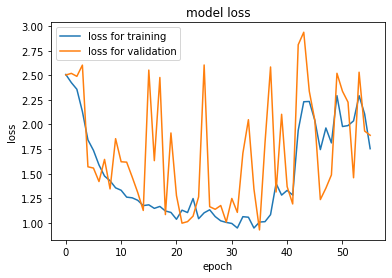

KeyError: 'acc'

In [11]:
def plot_history_loss(hist):
    # 損失値(Loss)の遷移のプロット
    plt.plot(hist.history['loss'],label="loss for training")
    plt.plot(hist.history['val_loss'],label="loss for validation")
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='best')
    plt.show()

def plot_history_acc(hist):
    # 精度(Accuracy)の遷移のプロット
    plt.plot(hist.history['acc'],label="loss for training")
    plt.plot(hist.history['val_acc'],label="loss for validation")
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc='best')
    plt.ylim([0, 1])
    plt.show()

plot_history_loss(hist)
plot_history_acc(hist)

In [ ]:
# カメラ番号をランダムに並び替えることでデータの偏りをなくそうというデータ作成プログラム


# def make_learndata(self):
#         data_name=self.file_name+"learn_0_"+str(rate)+".npy"
#         if (os.path.isfile(data_name)):
#             test=np.load(data_name)
#         else:
#             all_list = [np.empty((0,self.timesteps, self.width, self.height, 3), np.float)]*self.camera_num
#             tmp_list = [np.empty((0,self.timesteps, self.width, self.height, 3), np.float)]*self.camera_num
#             for i in range(0, self.labelData.shape[0]):
#                 #まずはすべての分だけ回す
#                 pro_size=20
#                 bar = int(i*pro_size/self.labelData.shape[0])
#                 pro_bar = ('=' * bar) + (' ' * (pro_size - bar))
#                 percent ='{:03f}'.format(i / self.labelData.shape[0] * 100.)
#                 print('\r [{0}] {1}%'.format(pro_bar, percent), end='')
                            
#                 for j in range(0,self.camera_num):
#                     for camera in range(0, self.camera_num):
#                         #カメラの台数だけ回す
#                         #tmp_list[camera]の同じ引数（番号）には角度を同じ分だけずらした同じ時間軸のsequenceが入っている．
#                         first_list =np.empty((0, self.width, self.height, 3), np.float)
#                         for l in range(0, self.timesteps):
#                             #timesteps分のndarrayを作る．
#                             img=self.learnData[camera,i+l]
#                             first_list =np.append(first_list, [img], axis=0)
#                         #あるカメラについて，１つのsequenceがfirst_listに出来上がっている状態．
#                         tmp_camera_num=self.camera_return(camera+j)
#                         tmp_list[tmp_camera_num]=np.append(tmp_list[tmp_camera_num], [first_list], axis=0)
    

#                 if(tmp_list[0].shape[0]>100 or i == self.labelData.shape[0]-1):
#                     #処理時間短縮のため，sequenceがtmp_listに溜まってきたら，全体に統合してまたtmp_listを初期化する．
#                     for camera in range(0, self.camera_num):
#                         all_list[camera]=np.append(all_list[camera], tmp_list[camera], axis=0)
#                         tmp_list[camera] = np.empty((0,self.timesteps, self.width, self.height, 3), np.float)
            
#             for camera in range(0, self.camera_num):
#                 print(all_list[camera].shape)
#                 data_name=self.file_name+"learn_"+str(camera)+"_"+str(rate)
#                 np.save(data_name, all_list[camera])
    
    
#     def make_labeldata(self):
#         data_name=self.file_name+"final_label_"+str(rate)+"_.npy"
#         if (os.path.isfile(data_name)):
#             test=np.load(data_name)
#         else:
#             test = np.empty((0,self.camera_num), np.float)
#             for i in range(0,self.labelData.shape[0]):
#                 for j in range(0, self.camera_num):
#                     tmp=self.camera_return(np.argmax(self.labelData[i])+j)
#                     a_one_hot = np.identity(self.camera_num)[tmp]
#                     print(a_one_hot)
#                     test = np.append(test, [a_one_hot], axis=0)
#             print(test.shape)
#             np.save(data_name, test)


    
#     def camera_return(self, num=0):
#         if(num<self.camera_num):
#             return num
#         else:
#             return num-self.camera_num